In [1]:
from scanbox.nlw_controller import *
from scanbox.utils import *
config = get_config()

box = ScanboxController('COM4',preferences = config['twophoton'])



[Scanbox] Master version 1.12.0
[Scanbox] Setting lcd token: 1
[Scanbox] Enabled the master-slave line drive.
[Scanbox] Disabled the tunable lens (fast-Z).
[Scanbox] Disabled current power
[Scanbox] PMT 0 gain: 0
[Scanbox] PMT 1 gain: 0
[Scanbox] PMT 2 gain: 0
[Scanbox] PMT 3 gain: 0
[Scanbox] Number of lines: 512
[Scanbox] Number of frames: -1
[Scanbox] Magnification: 0
[Scanbox] Set interrupt mask to: 3.
[Scanbox] Setting galvo dv per line to: 64.
[Scanbox] Setting galvo (y) gains to: [1.0, 1.189, 1.414, 1.682, 2.0, 2.378, 2.828, 3.364, 4.0, 4.757, 5.657, 6.727, 8.0].
[Scanbox] Setting resonant (x) gains to: [ 1.42   1.688  2.008  2.388  2.84   3.377  4.016  4.777  5.68   6.755
  8.033  9.552 11.36 ].
[Scanbox] Set the pockels range: dac 1 - pga 2.
[Scanbox] Reset the pockels lookup table.
[Scanbox] Set the sign of the horizontal axis (flipped).
[Scanbox] Disabled the external trigger.
[Scanbox] Disabled the continuous resonant mode
[Scanbox] Set warmup delay to 50.
[Scanbox] Mirror 

In [2]:
box.scan()

[Scanbox] Started scanning.


In [2]:
box.abort()
box.set_mirror_position(0)

[Scanbox] Stopped scanning.
[Scanbox] Mirror position 0.


In [3]:
box.exit_flag = True
box.usb.close()

In [3]:
import atsapi as ats
board = ats.Board(systemId=1, boardId=1)
# Configure the capture clock (trigger external/laser)
board.setCaptureClock(source = ats.FAST_EXTERNAL_CLOCK,
                      rate = ats.SAMPLE_RATE_USER_DEF,
                      edge = ats.CLOCK_EDGE_RISING,
                      decimation = 0)                        

In [5]:

channel_list = [ats.CHANNEL_A,ats.CHANNEL_B,ats.CHANNEL_C,ats.CHANNEL_D]
# configure the PMT channels
for channel in channel_list:
    board.inputControl(channel=channel,
                      coupling= ats.DC_COUPLING,
                      inputRange = ats.INPUT_RANGE_PM_1_V, 
                      impedance = ats.IMPEDANCE_50_OHM)
# Configure the trigger
board.setExternalClockLevel(65) # level in percent for the external clock (laser)
hsync_value = 0
trigger_level = 160
board.setTriggerOperation(operation = ats.TRIG_ENGINE_OP_J,
                          engine1 = ats.TRIG_ENGINE_J,
                          source1 = ats.TRIG_EXTERNAL,
                          slope1 = ats.TRIGGER_SLOPE_POSITIVE + int(hsync_value), # this depends on the HSYNC
                          level1 = int(trigger_level), # trigger level from 0 (-range) to 255 (+range)
                          engine2 = ats.TRIG_ENGINE_K,
                          source2 = ats.TRIG_DISABLE,
                          slope2 = ats.TRIGGER_SLOPE_POSITIVE,
                          level2 = 128)

board.setExternalTrigger(coupling = ats.DC_COUPLING,
                        range = ats.ETR_TTL)
board.setTriggerDelay(delay_samples=0) # no delay
board.setTriggerTimeOut(timeout_clocks = 0) # wait forever (0)
board.abortAsyncRead()

scanmode = 'unidirectional'
laser_frequency = 80000000
resonant_frequency = 8000
samples_per_pixel = int(np.round(laser_frequency / resonant_frequency*4 / 10000))

# configure the buffers
max_samples_per_record,bits_per_sample = board.getChannelInfo()
nlines = 512

if scanmode in [0,'uni','unidirectional']:
    post_trigger_samples = 5000*samples_per_pixel/4 # just one line...
    samples_per_record =  post_trigger_samples      # 10000/4 (1 sample every laser clock) samples per scan (back and forth)
    records_per_buffer = int(nlines)
else: # bidirectional
    post_trigger_samples = 9000*samples_per_pixel/4
    samples_per_record =  post_trigger_samples
    records_per_buffer = int(nlines/2)

# TODO: define the pixel_lookuptables here

# allocate the buffers
bytes_per_sample = 2;
nchannels = 4
nframes = 10 # continuous?

samples_per_buffer = samples_per_record * records_per_buffer * nchannels
bytes_per_buffer   = samples_per_buffer * bytes_per_sample

# allocate DMA buffer
nbuffers = 16
buffers = [ats.DMABuffer(c_sample_type = ctypes.c_uint16,
                         size_bytes = int(bytes_per_buffer)) for b in range(nbuffers)]

board.setRecordSize(preTriggerSamples = int(0),
                   postTriggerSamples = int(post_trigger_samples))


channel_selection = [1,1,1,1]

# configure acquisition
chan_sel = 0
for sel,channel in  zip(channel_selection, channel_list):
    if sel:
        chan_sel |=  channel        

board.beforeAsyncRead(
    channels = chan_sel,
    transferOffset = 0,
    samplesPerRecord = int(samples_per_record),
    recordsPerBuffer = int(records_per_buffer),
    recordsPerAcquisition = int(records_per_buffer*nframes),
    flags = ats.ADMA_EXTERNAL_STARTCAPTURE | ats.ADMA_NPT | ats.ADMA_INTERLEAVE_SAMPLES)

# post the buffers
for b in buffers:
    board.postAsyncBuffer(buffer=b.addr, bufferLength= int(bytes_per_buffer))

board.startCapture()
buffers_completed = 0
buffer_index = np.mod(buffers_completed, nbuffers)
# process a buffer and submit to the queue
b = buffers[buffers_completed % nbuffers]
try:
    board.waitAsyncBufferComplete(buffer=b.addr, timeout_ms = int(5000))
except Exception as err:
    if 'Timeout' in err.args:
        print('Timed out')
    else:
        raise(err)
print(b.buffer)

[64468 64516 64228 ... 64192 63204 32728]


In [7]:
nchannels = np.sum(channel_selection)

frame = np.array(b.buffer,dtype='uint16').reshape([nchannels,4,nlines,-1]).sum(axis = 1).reshape([nchannels,-1,nlines]).astype('uint16')
frame

array([[[62132, 61844, 59420, ..., 58572, 60704, 65396],
        [62564, 59596, 61240, ..., 61892, 60160, 65400],
        [62388, 60176, 61140, ..., 56656, 61400, 65376],
        ...,
        [62280, 60768, 61172, ..., 58396, 61944, 65420],
        [63840, 60780, 62424, ..., 59648, 61840, 65392],
        [62428, 60292, 60576, ..., 60616, 61020, 65376]],

       [[61692, 61816, 61060, ..., 61540, 59932, 65364],
        [60464, 61352, 59388, ..., 61260, 61356, 65388],
        [62436, 60008, 60932, ..., 59256, 60620, 65400],
        ...,
        [62096, 59660, 62904, ..., 60176, 60388, 65392],
        [62772, 61216, 60540, ..., 60784, 60232, 65360],
        [62916, 59532, 60340, ..., 57996, 62636, 65384]],

       [[63024, 60164, 60600, ..., 61096, 60004, 65432],
        [61876, 61160, 60384, ..., 60132, 59604, 65408],
        [59316, 60392, 61276, ..., 60932, 61048, 65352],
        ...,
        [61080, 61860, 58504, ..., 58444, 61296, 65432],
        [62472, 59388, 61276, ..., 61624, 594

<IPython.core.display.Javascript object>


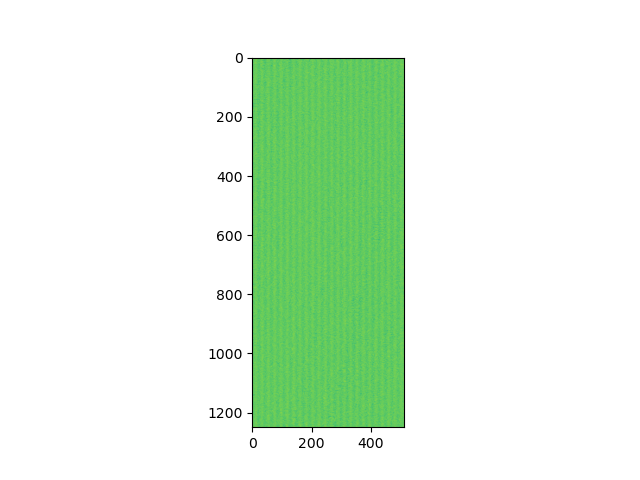

In [11]:
%matplotlib notebook
import pylab as plt
plt.imshow(frame[2])

In [9]:
sbox_set_status_message(box.usb)

In [15]:
box.scan()

[Scanbox] Started scanning.


In [92]:
box.set_continuous_resonant(True)


AttributeError: 'ScanboxController' object has no attribute 'set_continuous_resonant'

In [3]:
box.set_linescan_mode('bidi')


bytearray(b'5\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00')


In [5]:
from scanbox.nlw_controller import box_commands
box.cmd_queue.put(box_commands['version'])


bytearray(b'x\x00\x00\x00\xaa\x00\x00\x00U\x00\x00\x00')
Has read.
b'\x01\x0c\x00'


<BoxController(Thread-6, stopped 8432)>